# Dog Breed Classification using InceptionV3 CNN Model on Stanford Dogs Dataset
<!-- ## Abstract -->
The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. It was originally collected for fine-grain image categorization, a challenging problem as certain dog breeds have near identical features or differ in colour and age.

I have used the InceptionV3 CNN Model, which is pre-trained on the ImageNet dataset for classification. Data augementation has been used for making the model generalize better and also to avoid overfitting. The model achieved an accuracy of 80% on validation set, which is decent enough for this dataset.

# Installing and Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from IPython.display import SVG
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

2022-06-23 19:32:08.821718: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-23 19:32:08.824999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-23 19:32:08.825038: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

# Dataset

In [4]:
train_data_dir = "./data/dog-images/"
img_width, img_height = 224, 224 
channels = 3
batch_size = 64
num_images= 50
image_arr_size= img_width * img_height * channels

In [5]:
def get_images(image_dir):

    image_index = 0
    image_arr_size= img_width * img_height * channels
    images = np.ndarray(shape=(num_images, image_arr_size))
    labels = np.array([])                       

    for type in os.listdir(image_dir)[:50]:
        type_images = os.listdir(image_dir + type)
        labels= np.append(labels, type.split('-')[1])
        
        for image in type_images[:1]:
            image_file = os.path.join(image_dir, type + '/', image)
            image_data = mpimg.imread(image_file)
            image_resized = resize(image_data, (img_width, img_height), anti_aliasing=True)
            images[image_index, :] = image_resized.flatten()
            print (type, ':', image)
            image_index += 1

    return (images, labels)

def plot_images(instances, images_per_row=10, **options):
    size = img_width
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(img_width, img_height, channels) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((img_width, img_height * n_empty)))
    for row in range(n_rows):
        if (row == len(instances)/images_per_row):
            break
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.figure(figsize=(20,20))
    plt.imshow(image, **options)
    plt.axis("off")
    plt.savefig('dogs_images.png', transparent= True, bbox_inches= 'tight', dpi= 900)
    plt.show()

In [6]:
images, labels = get_images(train_data_dir)
plot_images(images)

FileNotFoundError: [Errno 2] No such file or directory: './data/dog-images/'

# Preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
    rescale= 1./255, #Dados serão multiplicados por este valor após aplicar os outros filtros
    shear_range= 0.2, #Em graus, sentido horário
    zoom_range= 0.2, #Random
    horizontal_flip= True, #Espelhamento Random
    rotation_range= 20, #Random
    width_shift_range= 0.2, #Fração da largura total 
    height_shift_range= 0.2,  #Fração da altura total 
    validation_split=0.2, #Fração de imagens reservadas para validação

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255,
    validation_split=0.2,
)


In [ ]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  #Diretório
    target_size= (img_width, img_height), #Tamanho para o qual as imagens serão convertidas
    color_mode= 'rgb', 
    batch_size= batch_size,  #Tamanho dos lotes
    class_mode= 'categorical', #Tipo de array de rótulo retornado
    subset='training', #Tipo de dado
    shuffle= True, #Embaralhamento
    seed= 1337 #Seed opcional para embaralhamento e transformações
) 

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1337
)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [ ]:
num_classes = len(train_generator.class_indices)  #classes e seus indíces
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)

16508


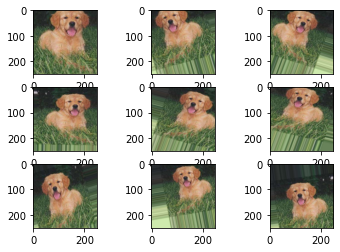

In [ ]:
img = load_img('./input/Images/n02099601-golden_retriever/n02099601_5.jpg')
data = img_to_array(img) #Converte a imagem em um numpy array
samples = expand_dims(data, 0) #insere uma dimensão de 
#comprimento 1 no eixo do índice de dimensão da forma da entrada
it = train_datagen.flow(samples, batch_size=1) #Gera lotes de imagem

for i in range(9): #Imagens transformadas
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image) #Cria o exemplo abaixo das imagens

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

# Model

In [ ]:
InceptionV3 = applications.InceptionV3(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
InceptionV3.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

In [ ]:
model = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False
#     print(layer,layer.trainable)
    
model.add(InceptionV3)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(120,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


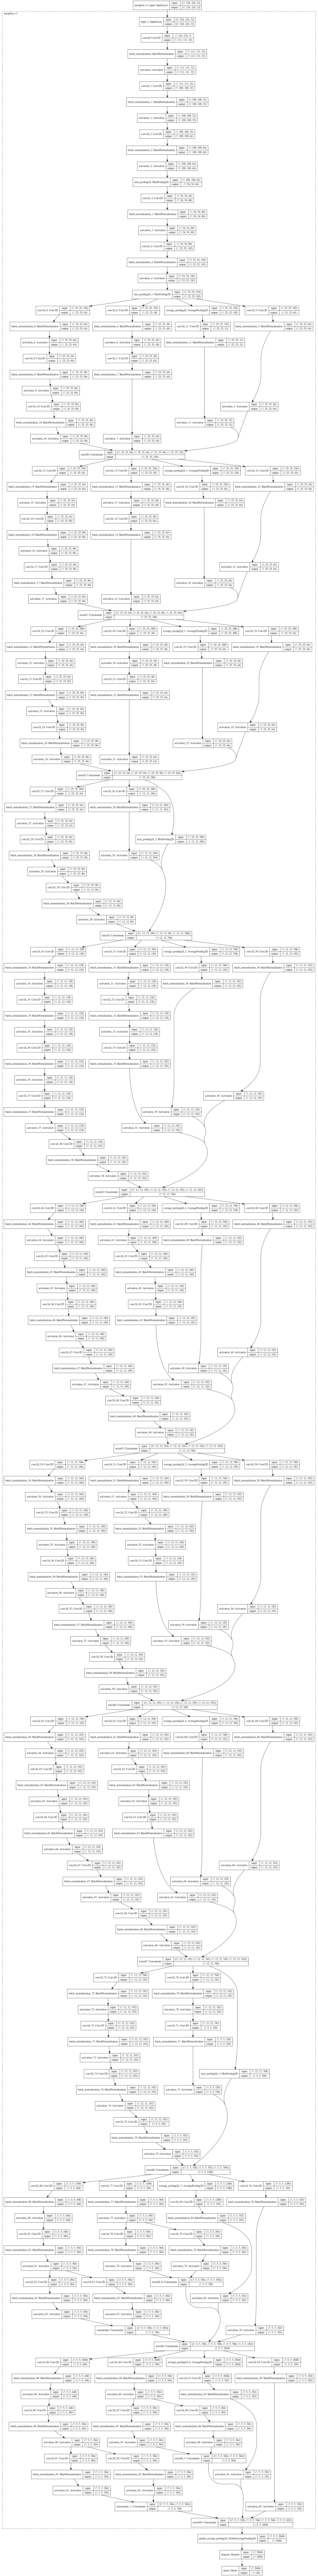

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

# Baseline Model Training

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [ ]:
history = model.fit(
    train_generator, 
    epochs = 30,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/30

Epoch 00001: val_loss improved from inf to 1.73642, saving model to baseline_model.h5
257/257 - 416s - loss: 3.4138 - accuracy: 0.2896 - val_loss: 1.7364 - val_accuracy: 0.6843
Epoch 2/30

Epoch 00002: val_loss improved from 1.73642 to 0.98991, saving model to baseline_model.h5
257/257 - 287s - loss: 1.6096 - accuracy: 0.6275 - val_loss: 0.9899 - val_accuracy: 0.7609
Epoch 3/30

Epoch 00003: val_loss improved from 0.98991 to 0.80997, saving model to baseline_model.h5
257/257 - 278s - loss: 1.1852 - accuracy: 0.6885 - val_loss: 0.8100 - val_accuracy: 0.7798
Epoch 4/30

Epoch 00004: val_loss improved from 0.80997 to 0.73872, saving model to baseline_model.h5
257/257 - 268s - loss: 1.0499 - accuracy: 0.7116 - val_loss: 0.7387 - val_accuracy: 0.7904
Epoch 5/30

Epoch 00005: val_loss improved from 0.73872 to 0.70333, saving model to baseline_model.h5
257/257 - 270s - loss: 0.9640 - accuracy: 0.7274 - val_loss: 0.7033 - val_accuracy: 0.7937
Epoch 6/30

Epoch 00006: val_loss impro

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)

64/64 [==============================] - 23s 352ms/step - loss: 0.6417 - accuracy: 0.8084
Validation Loss:  0.6416965126991272
Validation Accuracy:  0.8084479570388794


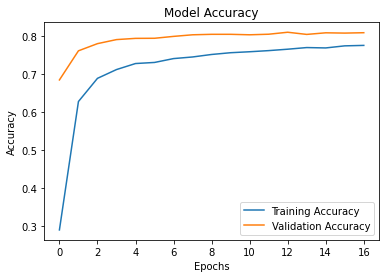

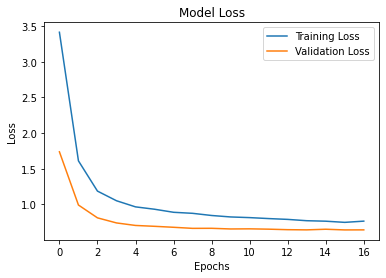

In [ ]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

In [1]:
import PySimpleGUI as sg
from tkinter import filedialog
from PIL import Image

layout = [[sg.Text("Bem vindo ao identificador de raças de cachorro", size=(40,5), font=("Arial",22))], [sg.Image(key='-OUT-')], [sg.Text(size=(40,5))], [sg.Text("Por favor insira uma imagem para ser identificada: ")], [sg.Button("Selecionar imagem")]]

# Create the window
window = sg.Window("Identificador de raças de cachorro", layout, element_justification='c')

# Create an event loop
while True:
    event, values = window.read()
    # End program if user closes window or
    # presses the OK button
    if event == "Selecionar imagem":
        filename = filedialog.askopenfilename()
        img = Image.open(filename).resize((400,400), Image.ANTIALIAS)
        img.save(fp="newimage.png")
        #img = load_img(filename)
        window['-OUT-'].update("newimage.png", size=(400,400))

    if event == sg.WIN_CLOSED:
        break

window.close()

/usr/lib/python3/dist-packages/PIL/Image.py:2763: DecompressionBombWarning: Image size (101100150 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
